# Learning Curves of Lucie-7B

In [1]:
import slugify
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

### 1. Load all benchmark results

Load CSV files ([evaluation_learning_curve_lucie.csv](evaluation_learning_curve_lucie.csv) and [evaluation_baselines.csv](evaluation_baselines.csv)).

In [2]:
# !pip install pandas matplotlib seaborn python-slugify
lucie_results = pd.read_csv(
    "../evaluation_learning_curve_lucie.csv"
)
baseline_results = pd.read_csv(
    "../evaluation_baselines.csv"
)

# Print some statistics
def unique(field): return len(lucie_results[field].unique())
print(f"✅ {unique('training_tokens')} Lucie checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")
def unique(field): return len(baseline_results[field].unique())
print(f"✅ {unique('model_name')} baseline checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")

✅ 45 Lucie checkpoints evaluated on 5 benchmarks (192 datasets)
✅ 9 baseline checkpoints evaluated on 5 benchmarks (184 datasets)


In [3]:
# Correction for the baselines !

baseline_results['training_phase'] = baseline_results['training_phase'].map({'main': '1_main', 'instruction': '4_instruct_full'})
def map_baseline_name_to_expe(model_name):
    if 'Croissant' in model_name:
        return 'CroissantLLM'
    if 'pythia' in model_name:
        return 'Pythia'
    if 'Mistral' in model_name:
        return 'Mistral'
    if 'Llama-3.1' in model_name:
        return 'Llama-3.1'
    if 'bloom' in model_name:
        return 'Bloom'
    if 'falcon' in model_name:
        return 'Falcon'
    else:
        return model_name

baseline_results['expe_name'] = baseline_results['model_name'].apply(map_baseline_name_to_expe)
baseline_results['model_name'] = 'Baseline'

In [4]:
results = pd.concat([lucie_results, baseline_results])

In [5]:
# Some print that can be useful
print(f"Model name: {results['model_name'].unique()}")
print(f"\nTraning phase: {results['training_phase'].unique()}")
print(f"\nExpe name: {results['expe_name'].unique()}")

print(f"\n{results[['model_name', 'training_phase', 'expe_name']].sort_values(['model_name', 'training_phase', 'expe_name']).drop_duplicates().to_string(index=False)}")

Model name: ['Lucie-7B' 'Baseline']

Traning phase: ['1_main' '2_extension' '3_annealing' '4_instruct_lora' '4_instruct_full'
 '4_instruct_full_deprecated']

Expe name: ['pretraining' 'rope500k' 'rope20M' '40M_tokens-mix1' '40M_tokens-mix3'
 '40M_tokens-mix2' '40M_tokens-mix4' '5B_tokens-mix2' '5B_tokens-mix3'
 '5B_tokens-mix4' '5B_tokens-mix1' '5B_tokens-mix6' '5B_tokens-mix5'
 'recipe2' 'recipe1' 'recipe7_fullpipe' 'recipe2_fullpipe'
 'recipe4_fullpipe' 'mix1' 'mix4' 'mix2' 'mix5' 'mix3' 'DemoCredi2Small'
 'DemoCredi2Small_v2' 'DemoCredi2' 'CroissantLLM' 'Llama-3.1' 'Mistral'
 'Bloom' 'Falcon' 'Pythia']

model_name             training_phase          expe_name
  Baseline                     1_main              Bloom
  Baseline                     1_main       CroissantLLM
  Baseline                     1_main             Falcon
  Baseline                     1_main          Llama-3.1
  Baseline                     1_main            Mistral
  Baseline                     1_main       

### 2. Setup a plot config (and some normalization of model/dataset names)

In the code cell below, `benchmarks` must be a dictionary:
* key: the name of the benchmark (will be plotted as a title)
* values: a list of dataset names that will be plotted together (see column `dataset` of [the CSV file](evaluation_learning_curve_lucie.csv))


In [6]:
# What to plot
BENCHMARKS = {
    "HF Leaderboard v1":
        [
            "arc_challenge",        "hellaswag",
            "mmlu",
            "mmlu_continuation",    "winogrande",
            "gsm8k",                "truthfulqa_mc2",
        ],
    "HF Leaderboard v2":
        [
            "leaderboard_bbh", "leaderboard_gpqa", "leaderboard_math_hard", "leaderboard_musr"
        ],
    "French Bench":
        [
            "french_bench_arc_challenge",   "french_bench_hellaswag",
            "french_bench_grammar",         "french_bench_vocab",
        ],
    "French Bench Generative":
        [
            "french_bench_fquadv2_genq",   "french_bench_multifquad",
            "french_bench_orangesum_abstract",         "french_bench_trivia",
        ],
    "Multilingual ARC benchmark":
        [
            "arc_fr",   "arc_es",
            "arc_de",   "arc_it",
        ],
}

# Output folder to save figures
OUTPUT_FOLDER = "../figs"

In [7]:
# Plot parameters
marker_types = {
    '1_main': 'o', 
    '2_extension': '*', 
    '3_annealing': 's', 
    '4_instruct_full': '^', 
    '4_instruct_full_deprecated': 'D', 
    '4_instruct_lora': 'v'
    }  

pattern_types = {
    '1_main': None, 
    '2_extension': '//', 
    '3_annealing': '--', 
    '4_instruct_full': '..', 
    '4_instruct_full_deprecated': '**', 
    '4_instruct_lora': '\\\\'
    }  

def is_valid_with_index(model_name, phase, expe, restrict_to):
    for idx, restrict in enumerate(restrict_to):
        r_model_name, r_phase, r_expe = restrict
        if (r_model_name is None or r_model_name == model_name) and \
           (r_phase is None or r_phase == phase) and \
           (r_expe is None or r_expe == expe):
            return True, idx  # Return True and the index
    return False, None  # Return False and None if no match is found

def can_be_rounded(x, ratio):
    return abs(x / ratio) % 1 <= 0.05

def format_big_integer(x):
    if x <= 1000: return str(int(x))
    if x <= 950_000 and can_be_rounded(x, 1000): return f"{x / 1_000:.0f}K"
    if x <= 950_000_000 and can_be_rounded(x, 1_000_000): return f"{x / 1_000_000:.0f}M"
    if x <= 950_000_000_000 and can_be_rounded(x, 1_000_000_000): return f"{x / 1_000_000_000:.0f}B"
    if x <= 950_000_000_000: return f"{x / 1_000_000_000:.1f}B"
    if can_be_rounded(x, 1_000_000_000_000): return f"{x / 1_000_000_000_000:.0f}T"
    return f"{x / 1_000_000_000_000:.1f}T"


In [8]:
def create_label(model_name, training_phase, expe_name):
    if model_name == 'Baseline':
        if 'main' in training_phase:
            return f"{expe_name}"
        if 'instruct' in training_phase:
            return f"{expe_name}-Instruct"
    elif model_name == 'Lucie-7B':
        if 'main' in training_phase:
            return f"{model_name}-Pretraining"
        if 'extension' in training_phase:
            return f"{model_name}-Extension ({expe_name})"
        if 'annealing' in training_phase:
            return f"{model_name}-Annealing ({expe_name})"
        if 'instruct' in training_phase:
            if 'lora' in training_phase:
                return f"{model_name}-Instruct (Lora - {expe_name})"
            if 'full' in training_phase:
                return f"{model_name}-Instruct (Full - {expe_name})"
            if 'deprecated' in training_phase:
                return f"{model_name}-Instruct (Full - Deprecated)"
            return f"{model_name}-Instruct ({expe_name})"
    raise NotImplementedError

In [9]:
def plot_results(lucie_results, title, benchmark_names, filename, restrict_to=None, bar_plot=False, xlogscale=True, display=False):
    # Apply the updated function
    lucie_results['allowed'], lucie_results['matched_index'] = zip(*lucie_results.apply(
        lambda row: is_valid_with_index(row['model_name'], row['training_phase'], row['expe_name'], restrict_to), 
        axis=1
    ))
    lucie_results = lucie_results[lucie_results['allowed']].sort_values('matched_index', ascending=True)

    ncols = min(2, len(benchmark_names))
    nrows = (len(benchmark_names) + 1) // ncols

    fig, ax = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))
    if title:
        plt.suptitle(title, fontsize=16, weight='bold', y=0.9)  # Reduce y value to bring the title closer
    
    # Ensure at least 50 different colors
    if len(lucie_results['expe_name'].unique()) > 20:
        warnings.warn("More than 20 experiments, using a larger color palette.")

    palette = sns.color_palette("tab20", n_colors=20)
    # colors = sns.color_palette("Spectral", num_colors)
    color_mapping = {expe: palette[i % 20] for i, expe in enumerate(lucie_results['expe_name'].unique())}
    xlabel = True
    norm_tokens = 1e09 if not xlogscale else 1

    # Score names and few shot
    benchmark2score = dict(zip(lucie_results['dataset'], lucie_results['score_name']))
    benchmark2fewshot = dict(zip(lucie_results['dataset'], lucie_results['num_fewshot']))

    # Select the benchmark
    for i_bench, benchmark_name in enumerate(benchmark_names):
        plt.subplot(nrows, ncols, i_bench+1)
        lucie_results_bench = lucie_results[lucie_results["dataset"] == benchmark_name].copy()

        title = f"{benchmark_name}\n"
        if benchmark_name in benchmark2score:
            score_name = benchmark2score[benchmark_name].replace(",none", "")
            title += f"({score_name}"
        if benchmark_name in benchmark2fewshot:
            num_fewshot = benchmark2fewshot[benchmark_name]
            if num_fewshot:
                try:
                    num_fewshot = int(num_fewshot)
                    title += f", {num_fewshot}-shot"
                except Exception:
                    num_fewshot = None
        title += ")"
        plt.title(title, weight='bold')

        # Loop on expe
        for (model_name, phase, expe), df in lucie_results_bench.groupby(['model_name', 'training_phase', 'expe_name'], sort=False):
            df.sort_values(by=['training_tokens', 'add_bos_token', 'chat_template', 'fewshot_as_multiturn'],
                           ascending=[True, True, False, False], inplace=True)
            label = create_label(model_name, phase, expe)
            
            if len(df) > 1 and phase != "1_main":
                warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
                df = df.iloc[[-1]]
                selected_data = df[['model_name', 'training_phase', 'expe_name', 'training_tokens', 'add_bos_token', 'chat_template', 'fewshot_as_multiturn']]
                formatted_data = "\n".join([f"{col}: {value}" for col, value in selected_data.iloc[0].items()])
                warnings.warn(f"Selecting: \n{formatted_data}")

            if phase not in marker_types:
                raise ValueError(f"Unknown phase: {phase}. Please define a marker for this phase.")
            if phase not in pattern_types:
                raise ValueError(f"Unknown phase: {phase}. Please define a marker for this phase.")
            marker = marker_types[phase]
            pattern = pattern_types[phase]
            color = color_mapping.get(expe, 'black')  # Default color

            #### PLOT IS HERE ####
            if bar_plot:
                df = df.iloc[-1]
                plt.bar(label, df['score'],  yerr=df['stderr'], label=label, color=color, edgecolor='grey', hatch=pattern)
                
            else:
                if len(df) > 1 and phase == "1_main":
                    plt.plot(df['training_tokens'], df['score'], label=f"{label} (checkpoints)", color=color, linewidth=1)
                    plt.plot(df.iloc[-1]['training_tokens'], df.iloc[-1]['score'], marker, label=label, color=color, linewidth=1)
                else:
                    plt.plot(df['training_tokens'], df['score'], marker, label=label, color=color)

        if xlogscale:
            plt.xscale('log')  # Set x-axis to log scale
            xticks_coordinates, _ = plt.xticks()
            previous = xticks_coordinates[0]
            new_xticks = [previous]
            for x in xticks_coordinates[1:]:
                if x / previous >= 10 - 1e-06:
                    new_xticks.append(3 * previous)
                new_xticks.append(x)
                previous = x
            if norm_tokens == 1:
                new_xticks_labels = [format_big_integer(x) for x in new_xticks]
                plt.xticks(new_xticks, new_xticks_labels)
            else:
                plt.xticks(new_xticks)

        if bar_plot:
            plt.xticks([])
            plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # You can adjust grid style (line type, transparency)
        else:
            plt.grid(True, linestyle='--', alpha=0.7)  # You can adjust grid style (line type, transparency)
            m, M = 100*1e9, 20*1e12
            plt.xlim(m, M)
            if xlabel:
                plt.xlabel("# training tokens" + (" (in billions)" if norm_tokens == 1e09 else (" (log scale)" if xlogscale else "")))

    # Adjust layout to add space for legend
    fig.subplots_adjust(bottom=0.2)

    # Set a single legend after the plots
    ax = plt.subplot(nrows, ncols, 1)
    handles, labels = ax.get_legend_handles_labels()
    if bar_plot:
        fig.legend(handles, labels, loc='lower center', fontsize=10, ncol=3)  # Legend after plots
    else:
        lucie_labels = [label for label in labels if label.startswith("Lucie")]
        other_labels = [label for label in labels if not label.startswith("Lucie")]
        sorted_labels = sorted(lucie_labels) + sorted(other_labels)
        sorted_handles = [handles[labels.index(label)] for label in sorted_labels]
        fig.legend(sorted_handles, sorted_labels, loc='lower center', fontsize=10, ncol=3)  # Legend after plots

    fig.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the plot to fit in the figure
    if filename:
        print(f"Saving {filename}...")
        plt.savefig(filename, facecolor='w', bbox_inches='tight')
        
    if display:
        plt.show()
    else:
        plt.close()

In [15]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Baseline', None, None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_chkpt')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to)


Saving ../figs/lucie_chkpt/hf-leaderboard-v1.png...
Saving ../figs/lucie_chkpt/hf-leaderboard-v2.png...
Saving ../figs/lucie_chkpt/french-bench.png...
Saving ../figs/lucie_chkpt/french-bench-generative.png...
Saving ../figs/lucie_chkpt/multilingual-arc-benchmark.png...


Saving ../figs/lucie_pipeline_official/hf-leaderboard-v1.png...


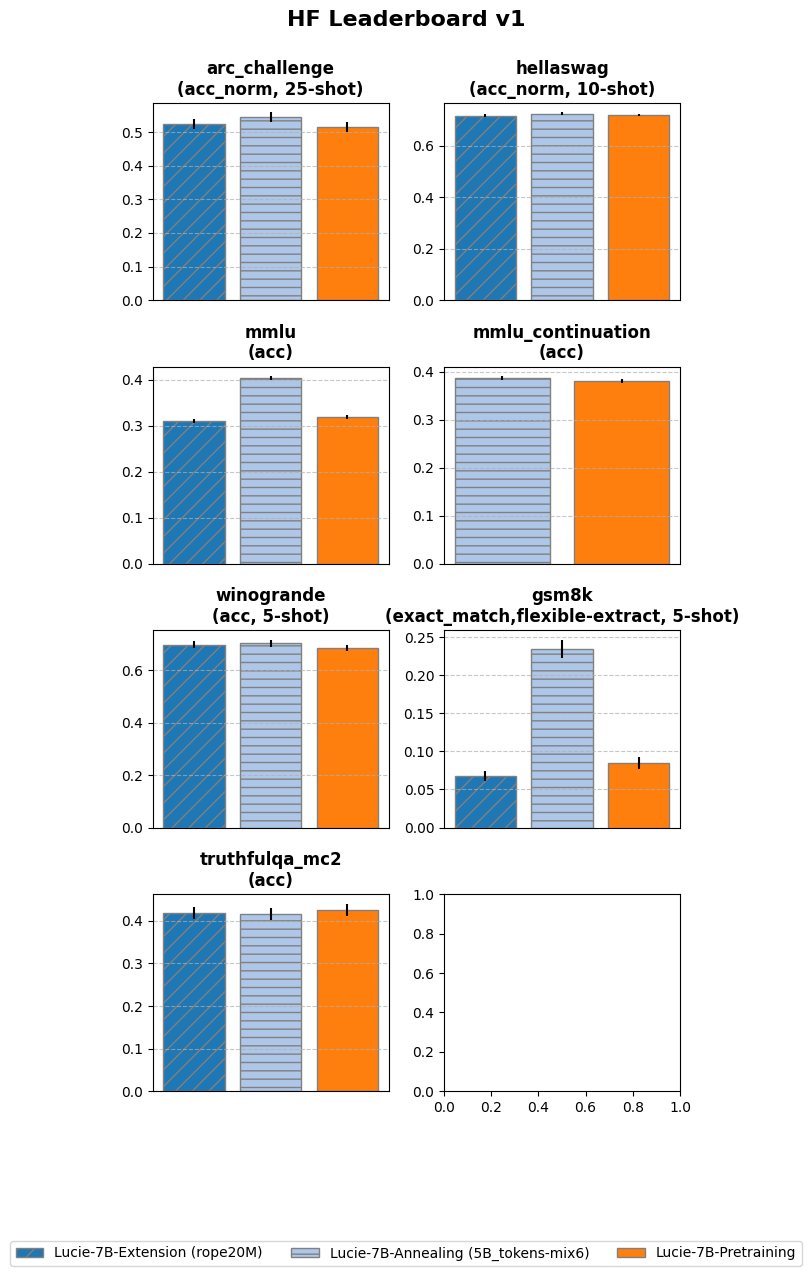

In [ ]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_pipeline_official')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

In [12]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Baseline', None, None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_pipeline_vs_baseline')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_pipeline_vs_baseline/hf-leaderboard-v1.png...
Saving ../figs/lucie_pipeline_vs_baseline/hf-leaderboard-v2.png...
Saving ../figs/lucie_pipeline_vs_baseline/french-bench.png...
Saving ../figs/lucie_pipeline_vs_baseline/french-bench-generative.png...
Saving ../figs/lucie_pipeline_vs_baseline/multilingual-arc-benchmark.png...


/tmp/ipykernel_3937091/1030942774.py:57: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix4 in arc_challenge.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_3937091/1030942774.py:61: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix4
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  warnings.warn(f"Selecting: \n{formatted_data}")
/tmp/ipykernel_3937091/1030942774.py:57: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix4 in hellaswag.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_3937091/1030942774.py:61: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix4
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  warnings.warn(f"Selecting: \

Saving ../figs/lucie_annealing/hf-leaderboard-v1.png...


KeyboardInterrupt: 

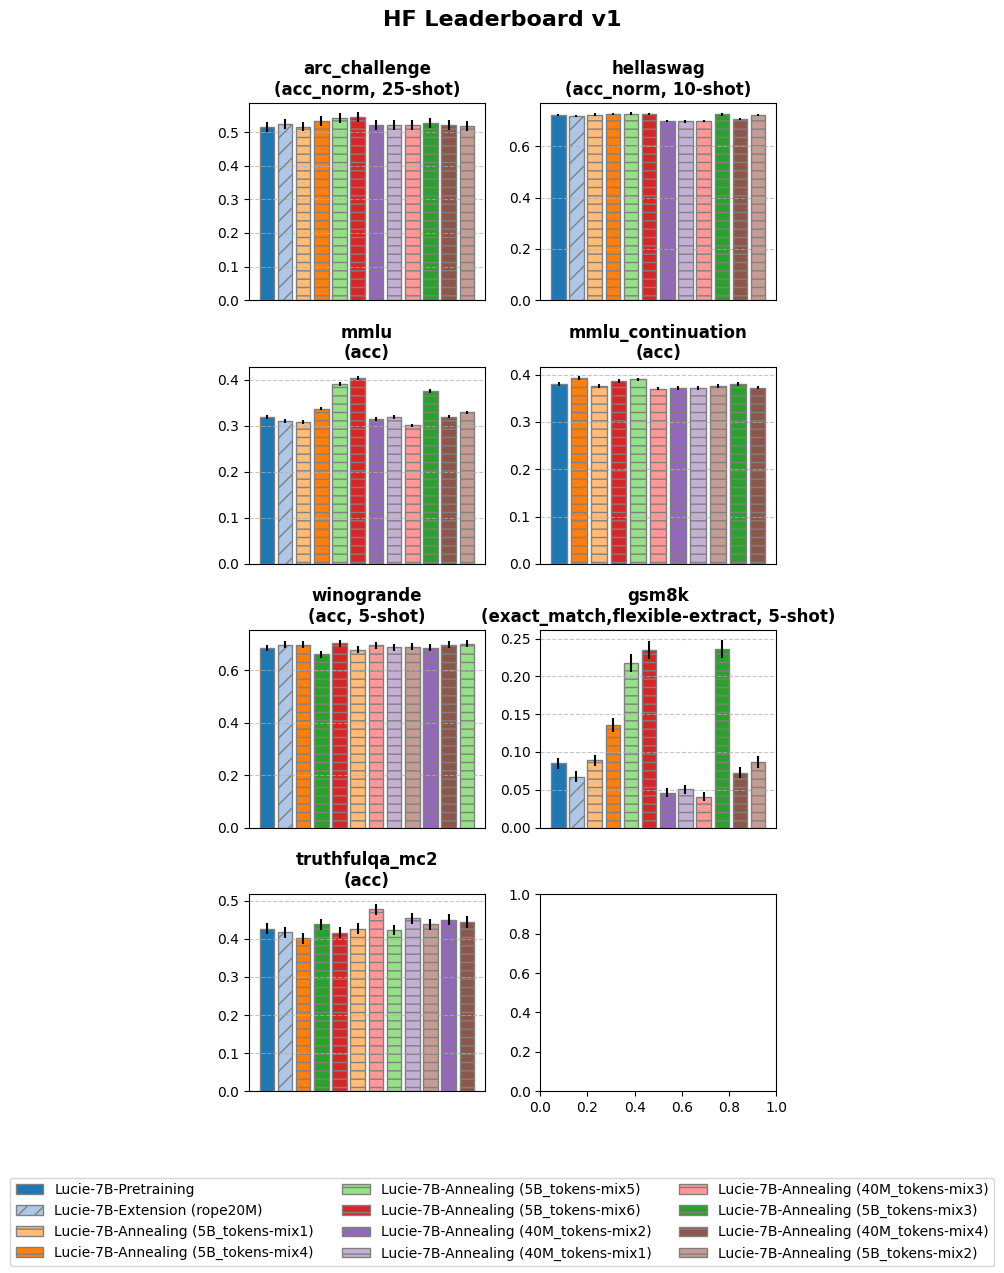

In [13]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_annealing')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

In [ ]:
restrict_to = [
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Lucie-7B', '4_instruct_full', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_full')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_instruct_full/hf-leaderboard-v1.png...
Saving ../figs/lucie_instruct_full/hf-leaderboard-v2.png...
Saving ../figs/lucie_instruct_full/french-bench.png...
Saving ../figs/lucie_instruct_full/french-bench-generative.png...
Saving ../figs/lucie_instruct_full/multilingual-arc-benchmark.png...


In [ ]:
restrict_to = [
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Lucie-7B', '4_instruct_full', None),
    ('Baseline', '4_instruct_full', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_full_vs_baselines')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_instruct_full_vs_baselines/hf-leaderboard-v1.png...
Saving ../figs/lucie_instruct_full_vs_baselines/hf-leaderboard-v2.png...
Saving ../figs/lucie_instruct_full_vs_baselines/french-bench.png...
Saving ../figs/lucie_instruct_full_vs_baselines/french-bench-generative.png...
Saving ../figs/lucie_instruct_full_vs_baselines/multilingual-arc-benchmark.png...
